# Other Models: IPW, Doubly Robust, Heterogeneity

This notebook provides complementary causal estimates using account-level summaries.
It does not replace the DiD/event-study; it triangulates results under different assumptions.


### Variable Names Used In Charts (Reader-Friendly)
- `Treatment`: exposed to at least one nudge during months 1-6 post-rollover.
- `Outcome`: invested at least once within 12 months post-rollover.
- `IPW`: inverse-probability weighting based on treatment propensity.
- `SMD`: standardized mean difference for treated-vs-control balance.


In [1]:

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import get_ipython

RANDOM_SEED = 42

ACCOUNTS_PATH = "data/accounts.csv"
DID_PATH = "data/did_ready.csv"

ip = get_ipython()
if ip is not None:
    ip.run_line_magic("matplotlib", "inline")

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 120
sns.set_theme(style="whitegrid")


In [2]:
accounts = pd.read_csv(ACCOUNTS_PATH)
panel = pd.read_csv(DID_PATH)

panel = panel[panel["active_flag"] == 1].copy()

np.random.seed(RANDOM_SEED)

accounts.head()


,account_id,rollover_month,baseline_balance,age_band,tenure_band,risk_tolerance,digital_engagement_score,advisor_flag,region,contactable_email,contactable_sms,preferred_channel,account_fe
0,1,2,13136.333754,65+,6y+,medium,0.170994,0,West,1,0,email,-0.767037
1,2,10,18338.788871,50-64,0-2y,medium,0.068868,0,West,0,0,email,0.841159
2,3,8,45576.527376,35-49,0-2y,medium,0.383328,0,West,1,0,email,-0.310257
3,4,6,29171.024268,50-64,0-2y,low,0.412686,0,West,1,0,email,-0.207711
4,5,6,20297.189859,18-34,6y+,medium,0.165568,0,East,1,0,email,0.667492


## Build Account-Level Dataset

Treatment is defined as any exposure during months 1–6 post rollover.
Outcome is investment within months 1–12 post rollover.


In [3]:
treat_window = (panel["months_since_rollover"] >= 1) & (panel["months_since_rollover"] <= 6)
outcome_window = (panel["months_since_rollover"] >= 1) & (panel["months_since_rollover"] <= 12)

acct_treat = (
    panel[treat_window]
    .groupby("account_id")["treatment_any"]
    .max()
    .rename("treat")
)

acct_outcome = (
    panel[outcome_window]
    .groupby("account_id")["invested_flag"]
    .max()
    .rename("outcome")
)

acct = accounts.merge(acct_treat, on="account_id", how="left")
acct = acct.merge(acct_outcome, on="account_id", how="left")

acct["treat"] = acct["treat"].fillna(0).astype(int)
acct["outcome"] = acct["outcome"].fillna(0).astype(int)

print(acct[["treat", "outcome"]].mean())


treat      0.17276
outcome    0.59566
dtype: float64


## Feature Matrix for Propensity Scores

In [4]:
acct["log_balance"] = np.log(acct["baseline_balance"])

cat_cols = ["age_band", "tenure_band", "risk_tolerance", "region", "preferred_channel"]
num_cols = ["log_balance", "digital_engagement_score", "advisor_flag", "contactable_email", "contactable_sms"]

X = pd.get_dummies(acct[cat_cols + num_cols], columns=cat_cols, drop_first=True)
X = sm.add_constant(X)
X = X.astype(float)

y_treat = acct["treat"].astype(int)


## IPW (Inverse Probability Weighting)
ATE estimated with stabilized propensity scores.


In [5]:
glm = sm.GLM(y_treat, X, family=sm.families.Binomial())
ps_model = glm.fit()

p = ps_model.predict(X)

p = np.clip(p, 0.01, 0.99)

y = acct["outcome"].values
t = acct["treat"].values

ate_ipw = np.mean(t * y / p - (1 - t) * y / (1 - p))

print("Average treatment effect on invest-within-12-month probability (IPW):", round(ate_ipw, 4))


Average treatment effect on invest-within-12-month probability (IPW): 0.3739


## Diagnostics Plots

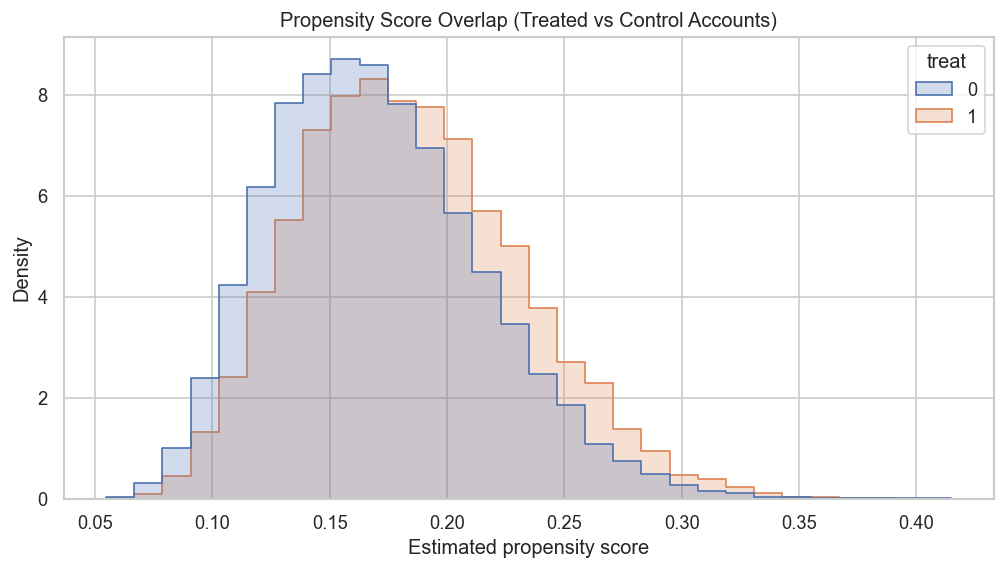

In [6]:

# Propensity score overlap is a basic check for whether IPW is likely to be stable.
ps_df = pd.DataFrame({
    "propensity": p,
    "treat": t.astype(int),
})

fig, ax = plt.subplots()
sns.histplot(
    data=ps_df,
    x="propensity",
    hue="treat",
    bins=30,
    stat="density",
    common_norm=False,
    element="step",
    ax=ax,
)
ax.set_title("Propensity Score Overlap (Treated vs Control Accounts)")
ax.set_xlabel("Estimated propensity score")
ax.set_ylabel("Density")
plt.show()


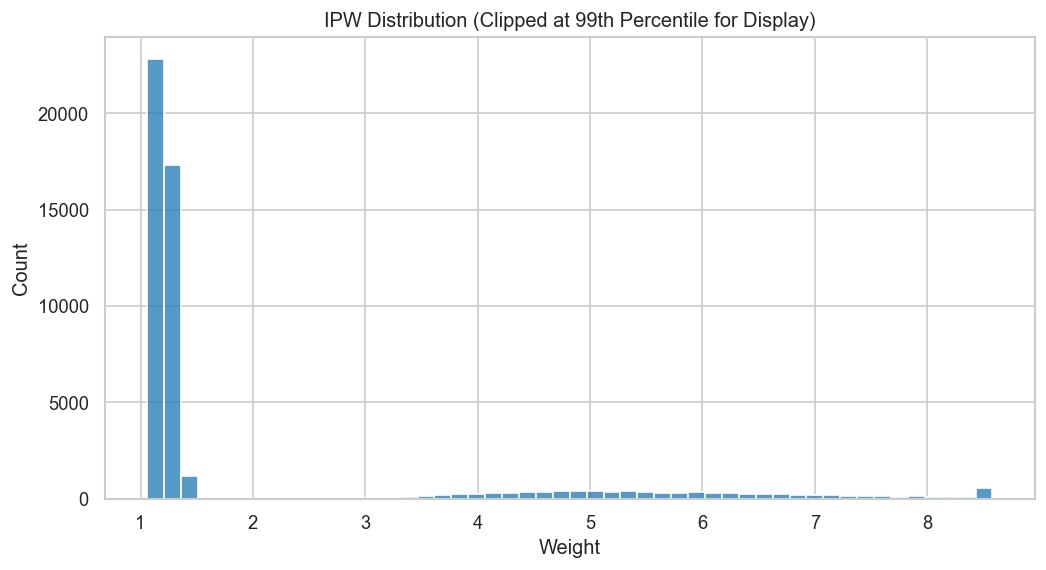

Treated ESS:  8045 (n=8,638)
Control ESS:  41232 (n=41,362)


In [7]:

# Extreme weights can dominate the estimator; plotting helps diagnose instability.
w = np.where(t == 1, 1.0 / p, 1.0 / (1.0 - p))
clip_hi = np.quantile(w, 0.99)
w_clip = np.clip(w, 0, clip_hi)

fig, ax = plt.subplots()
sns.histplot(w_clip, bins=50, color="#1f77b4", ax=ax)
ax.set_title("IPW Distribution (Clipped at 99th Percentile for Display)")
ax.set_xlabel("Weight")
ax.set_ylabel("Count")
plt.show()

def effective_sample_size(weights):
    weights = np.asarray(weights)
    return (weights.sum() ** 2) / (np.sum(weights ** 2) + 1e-12)

w_t = 1.0 / p[t == 1]
w_c = 1.0 / (1.0 - p[t == 0])
print(f"Treated ESS:  {effective_sample_size(w_t):.0f} (n={len(w_t):,})")
print(f"Control ESS:  {effective_sample_size(w_c):.0f} (n={len(w_c):,})")


## Doubly Robust (IPW + Outcome Regression)
Combines a treatment model and an outcome model for robustness.


In [8]:
X_out = X.copy()
X_out["treat"] = t

outcome_model = sm.OLS(y, X_out).fit()

X1 = X.copy()
X1["treat"] = 1
X0 = X.copy()
X0["treat"] = 0

mu1 = outcome_model.predict(X1)
mu0 = outcome_model.predict(X0)

ate_dr = np.mean((t * (y - mu1) / p) - ((1 - t) * (y - mu0) / (1 - p)) + (mu1 - mu0))

print("Average treatment effect on invest-within-12-month probability (Doubly Robust):", round(ate_dr, 4))


Average treatment effect on invest-within-12-month probability (Doubly Robust): 0.3738


## Bootstrap Confidence Intervals
This uses a lightweight nonparametric bootstrap on the estimated scores/predictions to quantify sampling variability for IPW and doubly robust ATEs.

In [9]:
N_BOOT = 500
rng = np.random.default_rng(RANDOM_SEED)

n = len(y)
boot_ipw = np.empty(N_BOOT)
boot_dr = np.empty(N_BOOT)

for b in range(N_BOOT):
    idx = rng.integers(0, n, n)

    y_b = y[idx]
    t_b = t[idx]
    p_b = p[idx]
    mu1_b = mu1[idx]
    mu0_b = mu0[idx]

    boot_ipw[b] = np.mean(t_b * y_b / p_b - (1 - t_b) * y_b / (1 - p_b))
    boot_dr[b] = np.mean((t_b * (y_b - mu1_b) / p_b) - ((1 - t_b) * (y_b - mu0_b) / (1 - p_b)) + (mu1_b - mu0_b))

ipw_ci = np.quantile(boot_ipw, [0.025, 0.975])
dr_ci = np.quantile(boot_dr, [0.025, 0.975])

print(f"IPW Average treatment effect on invest-within-12-month probability: {ate_ipw:.4f} | 95% bootstrap CI: [{ipw_ci[0]:.4f}, {ipw_ci[1]:.4f}]")
print(f"DR  Average treatment effect on invest-within-12-month probability: {ate_dr:.4f} | 95% bootstrap CI: [{dr_ci[0]:.4f}, {dr_ci[1]:.4f}]")


IPW Average treatment effect on invest-within-12-month probability: 0.3739 | 95% bootstrap CI: [0.3540, 0.3949]
DR  Average treatment effect on invest-within-12-month probability: 0.3738 | 95% bootstrap CI: [0.3664, 0.3815]


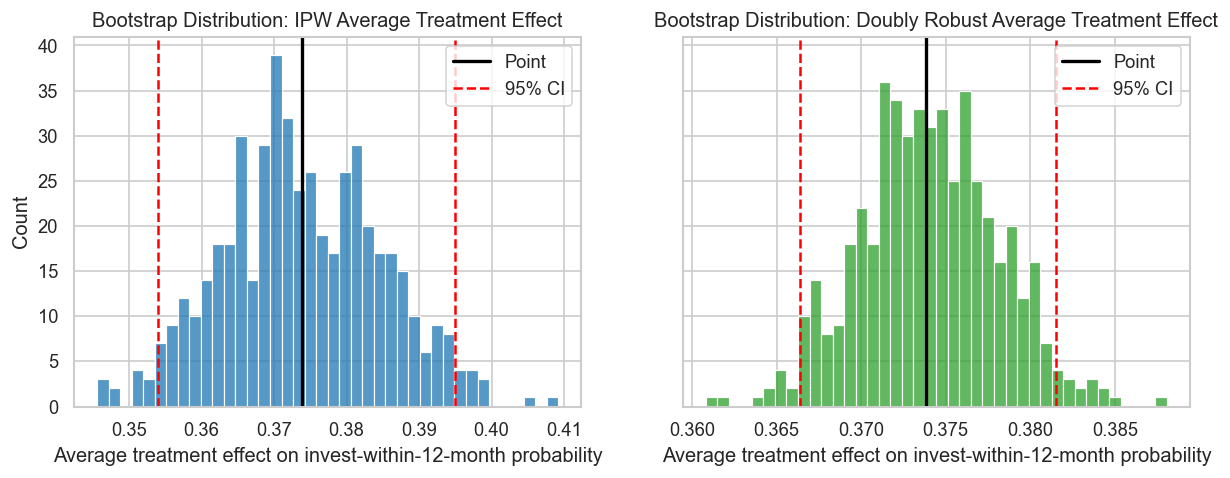

In [10]:

# Visualize bootstrap sampling uncertainty.
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.histplot(boot_ipw, bins=40, ax=axes[0], color="#1f77b4")
axes[0].axvline(ate_ipw, color="black", linewidth=2, label="Point")
axes[0].axvline(ipw_ci[0], color="red", linestyle="--", label="95% CI")
axes[0].axvline(ipw_ci[1], color="red", linestyle="--")
axes[0].set_title("Bootstrap Distribution: IPW Average Treatment Effect")
axes[0].set_xlabel("Average treatment effect on invest-within-12-month probability")
axes[0].legend()

sns.histplot(boot_dr, bins=40, ax=axes[1], color="#2ca02c")
axes[1].axvline(ate_dr, color="black", linewidth=2, label="Point")
axes[1].axvline(dr_ci[0], color="red", linestyle="--", label="95% CI")
axes[1].axvline(dr_ci[1], color="red", linestyle="--")
axes[1].set_title("Bootstrap Distribution: Doubly Robust Average Treatment Effect")
axes[1].set_xlabel("Average treatment effect on invest-within-12-month probability")
axes[1].legend()

plt.show()


In [11]:
def weighted_mean(x, w):
    return np.sum(w * x) / np.sum(w)


def weighted_var(x, w):
    m = weighted_mean(x, w)
    return np.sum(w * (x - m) ** 2) / np.sum(w)


def smd(x_t, x_c, w_t=None, w_c=None):
    if w_t is None:
        mt = x_t.mean()
        vt = x_t.var()
    else:
        mt = weighted_mean(x_t, w_t)
        vt = weighted_var(x_t, w_t)

    if w_c is None:
        mc = x_c.mean()
        vc = x_c.var()
    else:
        mc = weighted_mean(x_c, w_c)
        vc = weighted_var(x_c, w_c)

    denom = np.sqrt((vt + vc) / 2)
    if denom == 0:
        return 0.0
    return (mt - mc) / denom


def pretty_covariate_name(raw_name):
    direct_map = {
        "log_balance": "Log(starting rollover balance)",
        "digital_engagement_score": "Digital engagement score",
        "advisor_flag": "Has advisor support",
        "contactable_email": "Reachable by email",
        "contactable_sms": "Reachable by SMS",
    }
    if raw_name in direct_map:
        return direct_map[raw_name]

    if raw_name.startswith("age_band_"):
        return "Age band: " + raw_name.replace("age_band_", "")
    if raw_name.startswith("tenure_band_"):
        return "Client tenure: " + raw_name.replace("tenure_band_", "")
    if raw_name.startswith("risk_tolerance_"):
        return "Risk tolerance: " + raw_name.replace("risk_tolerance_", "")
    if raw_name.startswith("region_"):
        return "Region: " + raw_name.replace("region_", "")
    if raw_name.startswith("preferred_channel_"):
        return "Preferred channel: " + raw_name.replace("preferred_channel_", "")

    return raw_name.replace("_", " ").title()


covariates = [c for c in X.columns if c != "const"]

t_mask = (t == 1)
c_mask = (t == 0)

# ATE IPW weights
w_t = 1.0 / p[t_mask]
w_c = 1.0 / (1.0 - p[c_mask])

rows = []
for col in covariates:
    x = X[col].to_numpy()
    x_t = x[t_mask]
    x_c = x[c_mask]

    smd_raw = smd(x_t, x_c)
    smd_w = smd(x_t, x_c, w_t=w_t, w_c=w_c)

    rows.append({
        "covariate": col,
        "covariate_label": pretty_covariate_name(col),
        "smd_unweighted": smd_raw,
        "abs_smd_unweighted": abs(smd_raw),
        "smd_weighted": smd_w,
        "abs_smd_weighted": abs(smd_w),
    })

balance_df = pd.DataFrame(rows).sort_values("abs_smd_unweighted", ascending=False)

print("Top 15 covariates by pre-weighting imbalance")
print(balance_df[["covariate_label", "smd_unweighted", "smd_weighted"]].head(15).to_string(index=False))

summary = pd.DataFrame({
    "metric": ["mean |SMD|", "max |SMD|", "share |SMD| < 0.1"],
    "unweighted": [
        balance_df["abs_smd_unweighted"].mean(),
        balance_df["abs_smd_unweighted"].max(),
        (balance_df["abs_smd_unweighted"] < 0.1).mean(),
    ],
    "weighted": [
        balance_df["abs_smd_weighted"].mean(),
        balance_df["abs_smd_weighted"].max(),
        (balance_df["abs_smd_weighted"] < 0.1).mean(),
    ],
})

print("Balance summary")
print(summary.to_string(index=False))


Top 15 covariates by pre-weighting imbalance
               covariate_label  smd_unweighted  smd_weighted
Log(starting rollover balance)       -0.226497     -0.002834
                  Region: West       -0.157471      0.001679
                 Region: North        0.145648      0.000433
              Reachable by SMS        0.086696     -0.004637
           Has advisor support       -0.053733     -0.002539
                 Region: South        0.044907     -0.000562
            Reachable by email        0.032147     -0.000667
      Digital engagement score       -0.019653     -0.005981
      Preferred channel: inapp        0.012470     -0.003258
            Client tenure: 6y+       -0.010719      0.004176
           Client tenure: 3-5y       -0.009876     -0.000959
               Age band: 50-64       -0.009746     -0.003217
        Risk tolerance: medium        0.006416      0.003570
                 Age band: 65+        0.005446      0.003800
        Preferred channel: sms       -0.

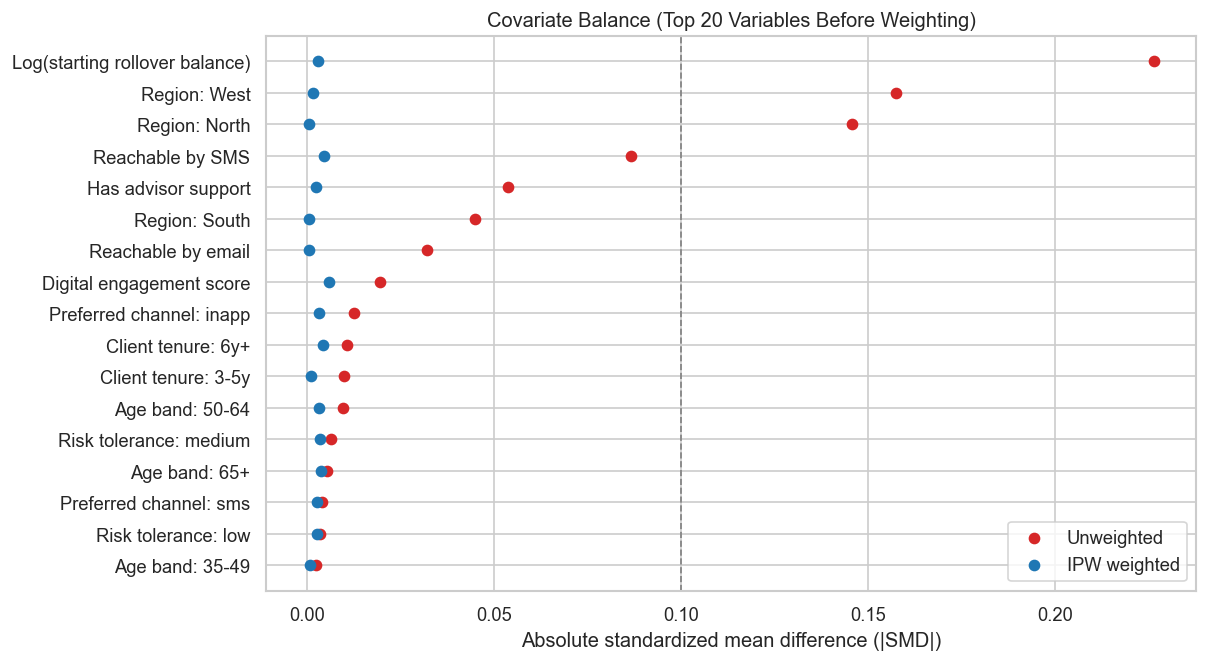

In [12]:

# Love plot: |SMD| before vs after weighting for the most imbalanced covariates.
top_k = 20
plot_df = balance_df.head(top_k).copy()
plot_df = plot_df.sort_values("abs_smd_unweighted")

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(plot_df["abs_smd_unweighted"], plot_df["covariate_label"], label="Unweighted", color="#d62728")
ax.scatter(plot_df["abs_smd_weighted"], plot_df["covariate_label"], label="IPW weighted", color="#1f77b4")
ax.axvline(0.1, color="#7f7f7f", linestyle="--", linewidth=1)
ax.set_xlabel("Absolute standardized mean difference (|SMD|)")
ax.set_title("Covariate Balance (Top 20 Variables Before Weighting)")
ax.legend(loc="lower right")

plt.show()


## Heterogeneous Effects by Segment
Segmented ATE using the same propensity scores.


In [13]:
acct["balance_band"] = pd.qcut(acct["baseline_balance"], 3, labels=["low", "mid", "high"])

seg_results = []
for band in ["low", "mid", "high"]:
    mask = acct["balance_band"] == band
    y_b = y[mask]
    t_b = t[mask]
    p_b = p[mask]
    ate_b = np.mean(t_b * y_b / p_b - (1 - t_b) * y_b / (1 - p_b))
    seg_results.append((band, ate_b))

seg_df = pd.DataFrame(seg_results, columns=["balance_band", "ate_ipw"])
print(seg_df)


  balance_band   ate_ipw
0          low  0.297000
1          mid  0.357912
2         high  0.466785


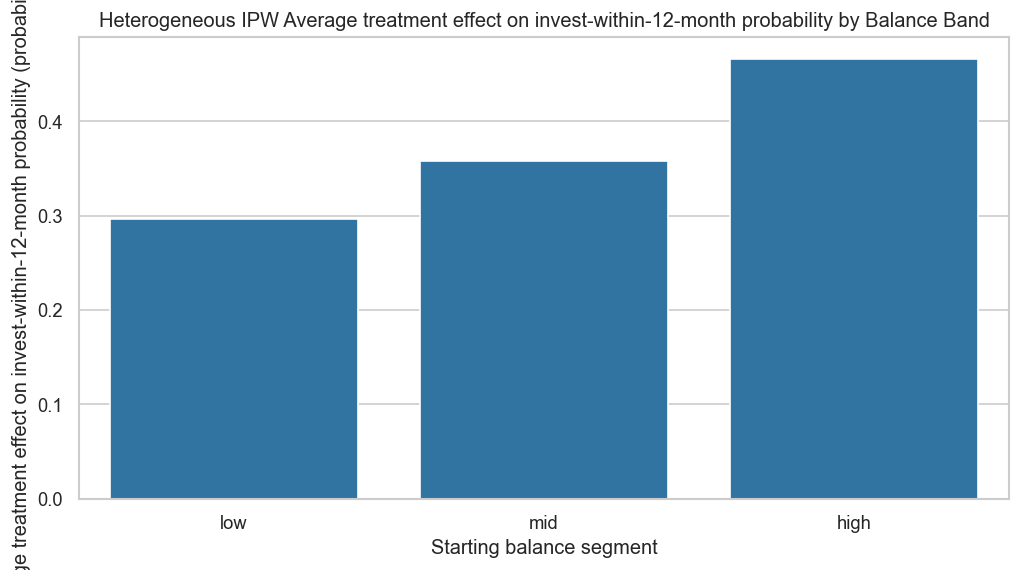

In [14]:

fig, ax = plt.subplots()
sns.barplot(data=seg_df, x="balance_band", y="ate_ipw", color="#1f77b4", ax=ax)
ax.set_title("Heterogeneous IPW Average treatment effect on invest-within-12-month probability by Balance Band")
ax.set_xlabel("Starting balance segment")
ax.set_ylabel("Average treatment effect on invest-within-12-month probability (probability points)")

plt.show()


## Notes
- These models use account-level summaries rather than the full panel.
- Results are expected to be directionally consistent with the DiD estimates.
